In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test  = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")


In [3]:
train.shape, test.shape

((42000, 785), (28000, 784))

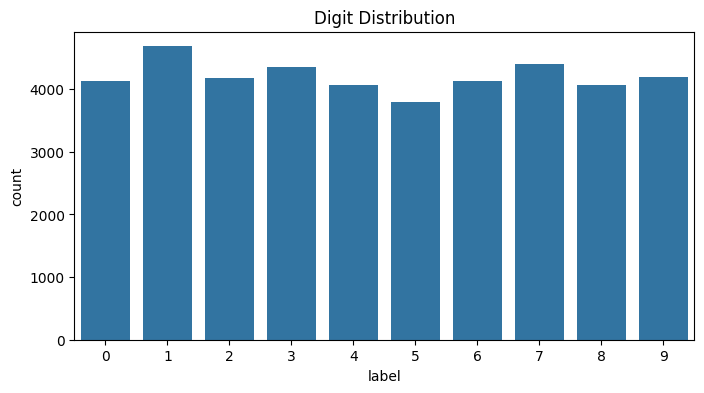

In [4]:
plt.figure(figsize=(8,4))
sns.countplot(x=train['label'])
plt.title("Digit Distribution")
plt.show()


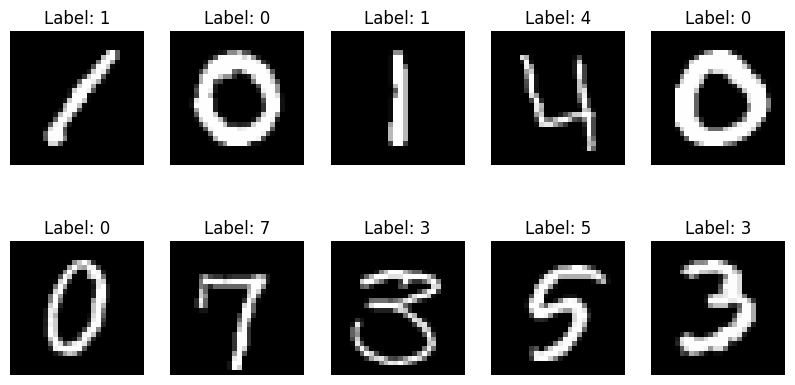

In [5]:
fig, axes = plt.subplots(2,5, figsize=(10,5))

for i, ax in enumerate(axes.flat):
    img = train.iloc[i, 1:].values.reshape(28,28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {train.iloc[i,0]}")
    ax.axis('off')


In [6]:
X = train.drop("label", axis=1)
y = train["label"]


In [7]:
X = X / 255.0
test = test / 255.0

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

pred = lr.predict(X_val)
print("Logistic Accuracy:", accuracy_score(y_val, pred))


Logistic Accuracy: 0.919047619047619


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

pred = rf.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, pred))


Random Forest Accuracy: 0.9629761904761904


In [12]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

pred = svm.predict(X_val)
print("SVM Accuracy:", accuracy_score(y_val, pred))


SVM Accuracy: 0.973452380952381


In [16]:
X_train_cnn = X_train.values.reshape(-1,28,28,1)
X_val_cnn   = X_val.values.reshape(-1,28,28,1)
X_test_cnn  = test.values.reshape(-1,28,28,1)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1), padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 3 
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Fully Connected
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=3,            
    restore_best_weights=True
)


In [23]:
history = model.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stop]
)


Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.9937 - val_loss: 0.0363
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9962 - loss: 0.0129 - val_accuracy: 0.9949 - val_loss: 0.0274
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.9937 - val_loss: 0.0297
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9971 - loss: 0.0084 - val_accuracy: 0.9948 - val_loss: 0.0306
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9968 - loss: 0.0114 - val_accuracy: 0.9933 - val_loss: 0.0388


In [30]:
from sklearn.metrics import confusion_matrix
y_val_pred = model.predict(X_val_cnn)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)


263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


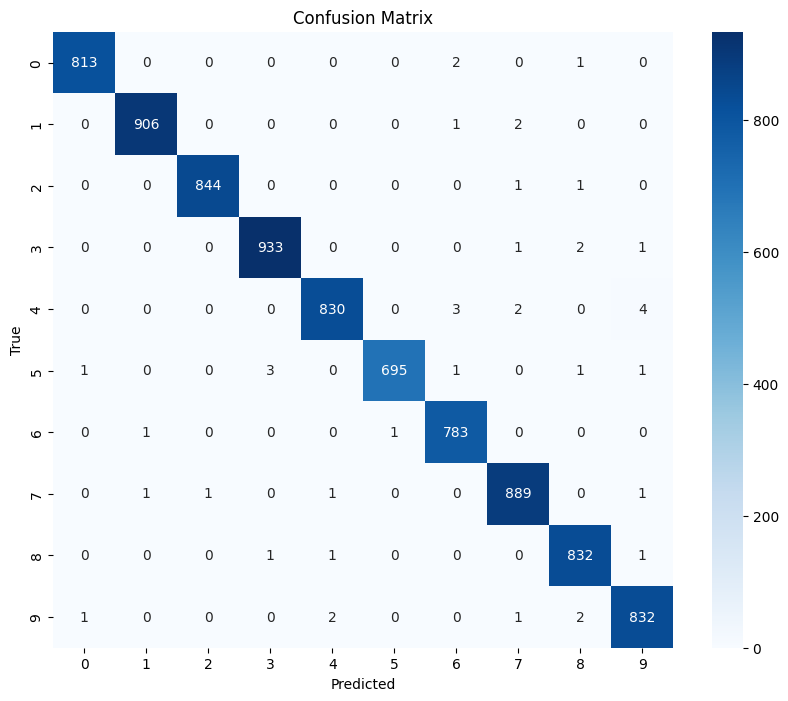

In [31]:
cm = confusion_matrix(y_val, y_val_pred_labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [32]:
errors = (y_val_pred_labels != y_val.values)

X_errors = X_val_cnn[errors]
y_true_errors = y_val.values[errors]
y_pred_errors = y_val_pred_labels[errors]
len(X_errors)


43

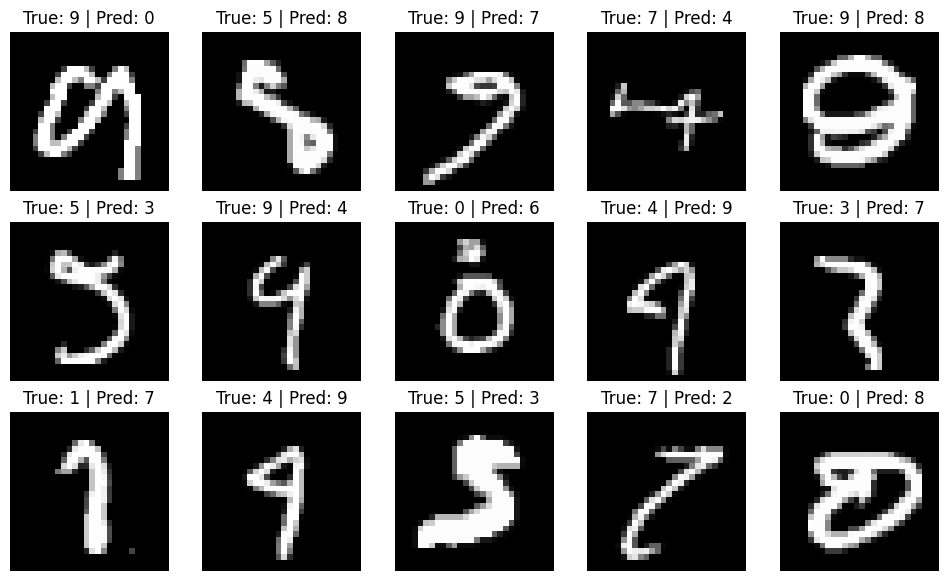

In [33]:
fig, axes = plt.subplots(3,5, figsize=(12,7))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_errors[i].reshape(28,28), cmap='gray')
    ax.set_title(f"True: {y_true_errors[i]} | Pred: {y_pred_errors[i]}")
    ax.axis('off')


In [35]:
from sklearn.metrics import classification_report

y_val_pred = model.predict(X_val_cnn)

y_val_pred_labels = y_val_pred.argmax(axis=1)
print(classification_report(y_val, y_val_pred_labels))


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       816
           1       1.00      1.00      1.00       909
           2       1.00      1.00      1.00       846
           3       1.00      1.00      1.00       937
           4       1.00      0.99      0.99       839
           5       1.00      0.99      0.99       702
           6       0.99      1.00      0.99       785
           7       0.99      1.00      0.99       893
           8       0.99      1.00      0.99       835
           9       0.99      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400

